In [28]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [10]:
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters
    
    X_shortcut = X   
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same',name=conv_name_base+'2b',kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name= bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid',name=conv_name_base+'2c',kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+'2c')(X)


    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)

    
    return X

In [11]:
def convolutional_block(X, f, filters, stage, block, s = 2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters   

    X_shortcut = X
 
    X = Conv2D(F1, (1, 1), strides = (s,s),padding='valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    X = Conv2D(filters=F2,kernel_size=(f,f),padding='same',strides=(1,1),name=conv_name_base+'2b',kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    

    X = Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),name=conv_name_base+'2c',kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+'2c')(X)


    X_shortcut = Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s),name=conv_name_base+'1',kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3,name=bn_name_base+'1')(X_shortcut)

 
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    
    return X

In [12]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):

    X_input = Input(input_shape)


    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3,  [128,128,512], stage=3, block='b')
    X = identity_block(X, 3,  [128,128,512], stage=3, block='c')
    X = identity_block(X, 3,  [128,128,512], stage=3, block='d')

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3,  [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3,  [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3,  [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3,  [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3,  [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3,  [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3,  [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D((2,2))(X)

    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    

    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [13]:
model=ResNet50(input_shape=(64,64,3),classes=6)

In [14]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
def load_dataset():
    train_dataset = h5py.File('C:/Users/Girish/Downloads/Jupyter notebooks/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('C:/Users/Girish/Downloads/Jupyter notebooks/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [25]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [26]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

X_train = X_train_orig/255.
X_test = X_test_orig/255.

Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [30]:
history=model.fit(X_train,Y_train,batch_size=45,epochs=24)

Epoch 1/24
1080/1080 [==============================] - 97s 90ms/step - loss: 1.7821 - accuracy: 0.4778
Epoch 2/24
1080/1080 [==============================] - 99s 92ms/step - loss: 0.5119 - accuracy: 0.8120
Epoch 3/24
1080/1080 [==============================] - 108s 100ms/step - loss: 0.2508 - accuracy: 0.9111
Epoch 4/24
1080/1080 [==============================] - 101s 94ms/step - loss: 0.3236 - accuracy: 0.9019
Epoch 5/24
1080/1080 [==============================] - 93s 86ms/step - loss: 0.3031 - accuracy: 0.9231
Epoch 6/24
1080/1080 [==============================] - 89s 82ms/step - loss: 0.1625 - accuracy: 0.9444
Epoch 7/24
1080/1080 [==============================] - 90s 83ms/step - loss: 0.1389 - accuracy: 0.9639
Epoch 8/24
1080/1080 [==============================] - 89s 82ms/step - loss: 0.2573 - accuracy: 0.9250
Epoch 9/24
1080/1080 [==============================] - 88s 82ms/step - loss: 0.0925 - accuracy: 0.9685
Epoch 10/24
1080/1080 [==============================] - 98s 

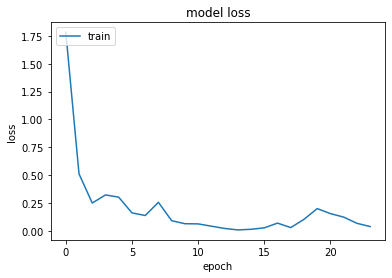

In [31]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

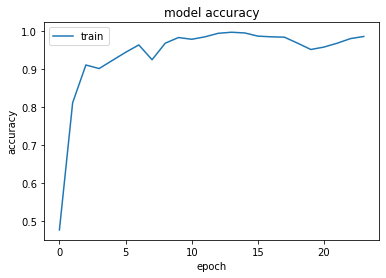

In [32]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('model accuracy')
plt.legend(['train', 'test'], loc='upper left')

In [33]:
pred=model.evaluate(X_test,Y_test)
print("loss="+str(pred[0]))
print("accuracy="+str(pred[1]))

120/120 [==============================] - 21s 179ms/step
loss=0.2657895515362422
accuracy=0.9583333134651184
